# Analysis of the LLM Runs
This will use the the event_study file to analyse the performance across the different strategies. The strategies tested in this file are:

- Base case (consensus estimates from Wall Street analysts on the sellside)
- Llama (zero shot)
- Llama (chain of thought)

In [1]:
# Install signal_lab if it isn't already loaded
%package install bloomberg.bquant.signal_lab=1.5.2

Running: micromamba install bloomberg.bquant.signal_lab=1.5.2 --yes --log-level=error

  Package                                                  Version  Build                Channel                                      Size
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + libboost-headers                                        1.84.0  ha770c72_2           conda-forge                                  14MB
  + zlib-ng                                                  2.0.7  h0b41bf4_0           conda-forge                                  95kB
  + gettext-tools                                           0.23.1  h5888daf_0           conda-forge                                   3MB
  + libasprintf                                             0.2

In [2]:
import json
import pandas as pd
import numpy as np
import importlib
import os

import event_study as es
import utils.tradegeneration as tg

from bloomberg.bquant.signal_lab.workflow.utils import get_sandbox_path
from utils.backtest_params import get_analyst_params, get_universe_params

from prompts import SYSTEM_PROMPTS

import plotly.express as px
from plotly.subplots import make_subplots
from utils.s3_helper import S3Helper

datapack_path = f"{get_sandbox_path()}/tmp/fs/datapack"

In [3]:
datapack_path

's3://awmgd-prod-finml-02-sandbox-user/bclarke16/tmp/fs/datapack'

In [4]:
importlib.reload(es)
importlib.reload(tg)

<module 'utils.tradegeneration' from '/project/utils/tradegeneration.py'>

## Base case

This is used as the baseline and is the consensus estimates based on Wall Street sellside analysts. The recommendations are aggregated across a number of analysts. If the rating is 5, this is a strong buy, if the rating is a 1, this is a strong sell. 

In [5]:
# STEP 1: Get the data 
start = '2020-02-07'
end = '2025-03-31'
universe_name = 'INDU Index'
universe, benchmark, trading_calendar = get_universe_params(start, end, universe_name, datapack_path)
analyst_ratings = get_analyst_params(start, end, datapack_path)

In [6]:
# Get the analyst ratings for each company in the Dow Jones
analyst_ratings.bind_universe(universe)
ratings_df = analyst_ratings.df().ffill()

100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


In [7]:
ids = universe.df().columns

100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


In [8]:
ids

Index(['BBG000B9XRY4', 'BBG000BBJQV0', 'BBG000BBS2Y0', 'BBG000BCQZS4',
       'BBG000BCSST7', 'BBG000BF0K17', 'BBG000BH4R78', 'BBG000BJ81C1',
       'BBG000BKZB36', 'BBG000BLNNH6', 'BBG000BMHYD1', 'BBG000BMX289',
       'BBG000BN2DC2', 'BBG000BNSZP1', 'BBG000BP52R2', 'BBG000BPD168',
       'BBG000BPH459', 'BBG000BR2B91', 'BBG000BR2TH3', 'BBG000BSXQV7',
       'BBG000BVPV84', 'BBG000BW8S60', 'BBG000BWLMJ4', 'BBG000BWXBC2',
       'BBG000C0G1D1', 'BBG000C3J3C9', 'BBG000C5HS04', 'BBG000C6CFJ5',
       'BBG000CH5208', 'BBG000DMBXR2', 'BBG000GZQ728', 'BBG000H556T9',
       'BBG000HS77T5', 'BBG000K4ND22', 'BBG000PSKYX7', 'BBG00BN96922'],
      dtype='object', name='ID')

In [9]:
# STEP 2: Convert the recommendations into a list of trades
def rating(rating: float) -> int:
    if rating > 3.5:
        return 1
    if rating < 2.5:
        return -1
    else:
        return 0

def trade_direction(trade: int) -> str:
    if trade == 1:
        return "BUY"
    if trade == -1:
        return "SELL"
    else:
        return "HOLD"

def convert_to_trade_view(df: pd.DataFrame) -> pd.DataFrame:
    trade_dfs = []
    # loop through each column
    for security in ratings_df.columns:
        # convert to a numerical buy/ sell/ hold
        df[security] = df[security].apply(rating)
        diff_df = df[[security]]
        diff_df['diff'] = diff_df[security].diff().fillna(1)
        # look for where the rating has changed and filter on this date
        trade_df = diff_df[diff_df['diff'] != 0]
        # change back to BUY/ SELL/ HOLD
        trade_df[security] = trade_df[security].apply(trade_direction)
        # reformat the dataframe so that it is Date | Security | trade direction
        trade_df['Security'] = security
        final_df = trade_df.reset_index().rename(columns={security:'Decision', 'DATE':'Date'})[['Date','Security', 'Decision']].reset_index()
        trade_dfs.append(final_df)
    return pd.concat(trade_dfs)

trade_analyst_recommendations = convert_to_trade_view(ratings_df.copy(deep=True)).sort_values('Date')

### Backtest Base Strategy

We can see the list of recommendations that this generates broken down by Date, security and direction. This is then passed into the Event Backtester class in the event_study.py file to turn this trade report into a portfolio that can be examined further. The trade report generated will show only where the rating has changed recommendations. It does not show the period if the recommendation did not change. This is why this dataframe is 119 rows vs the longer LLM trade reports where the recommendation is shown irrespective of whether there was a change.

In [10]:
trade_analyst_recommendations[['Date', 'Security', 'Decision']] # This is where the rating has changed only

ID       Date      Security Decision
0  2020-02-07  BBG000B9XRY4      BUY
0  2020-02-07  BBG000BKZB36      BUY
0  2020-02-07  BBG000BLNNH6     HOLD
0  2020-02-07  BBG000C3J3C9      BUY
0  2020-02-07  BBG000HS77T5     HOLD
..        ...           ...      ...
9  2025-02-03  BBG000BLNNH6      BUY
3  2025-02-18  BBG000BJ81C1      BUY
3  2025-03-10  BBG000BCQZS4     HOLD
4  2025-03-14  BBG000BCQZS4      BUY
4  2025-03-21  BBG000BJ81C1     HOLD

[119 rows x 3 columns]

In [11]:
# STEP 3: Backtest the strategy using the EventBacktest
backtest = es.EventBacktest(start=start, 
                            end=end, 
                            universe_name=universe_name, 
                            data_pack_path=datapack_path)
base_results = backtest.run(trade_analyst_recommendations, 'base')

100%|██████████| 117/117 [00:44<00:00,  2.64it/s]


### Calculate and Plot Return Metrics
We calculate the return of this strategy and compare it to the benchmark (ie a passive fund investing in the Dow Jones over the same time period.) 

The Base Strategy shows outperformance of the benchmark over the last 5 years. Note that this does not take into account transaction costs, but this is a good indication of the viability of a strategy and a standard comparison for the strategies created by the LLMs

In [12]:
# calculate the returns
df_strategy_return, df_benchmark_return = backtest.get_return_data()

In [13]:
df_chart = df_strategy_return.merge(df_benchmark_return, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)_x': 'Return - BASE', 'Cum. Return (Gross)_y':'Return - Benchmark'})[['Return - BASE','Return - Benchmark']]

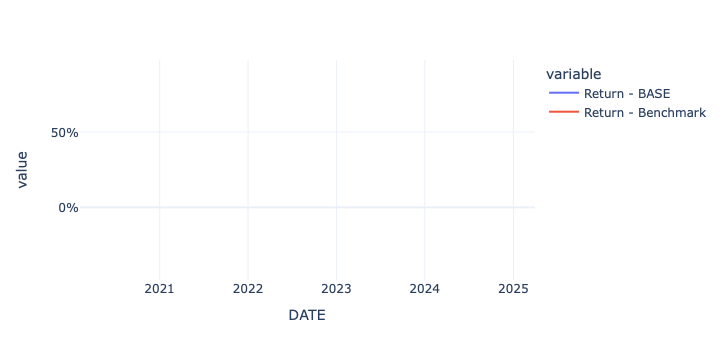

In [14]:
fig = px.line(df_chart)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

In [15]:
base_results.plot_analytics()

## LLM Strategies

Now we can move onto the strategies created by the LLMs to BUY, SELL or HOLD. These are stored by the StrategyConstructor class in the Results folder. 

Loop through each of the Stock Price strategies in the Results folder. This will test open source and closed source models. The steps to do this are to read all of the json files and generate a trade report for them. 

In [16]:
# STEP 1: Go through the saved results in the Results folder and generate the trade reports
def find_prompt_type(prompt):
    for prompt_type in SYSTEM_PROMPTS.keys():
        if SYSTEM_PROMPTS[prompt_type]['prompt'] == prompt:
            return prompt_type
    return None


results = {}
# Loop through all of the results 
for file in os.listdir('Results/Stock Price'):
    # filter out the non-json files in the folder
    if file[-5:] == '.json':
        
        with open(f'Results/Stock Price/{file}', 'rb') as f:
            result = json.load(f)
            # find the system prompt to add into the name
            prompt_type = find_prompt_type(result['system_prompt'])
            # store the trade report in the results dictionary
            results[f"{result['model']} - {prompt_type}"] = tg.generate_trade_report(result['results'])

### Loop through each of the trade reports

Generate the portfolios and strategy metrics for each of the trade reports generated from the models. 

In [17]:
# STEP 2: Event backtest each of the results and store in the trade_results dictionary
trade_results = {}
trade_analytics = {}
for key in results.keys():
    trades = pd.DataFrame(results[key])
    trade_analytics[key] = backtest.run(trades,'key')
    df_strategy, df_benchmark = backtest.get_return_data()
    trade_results[key] = df_strategy

100%|██████████| 117/117 [00:40<00:00,  2.87it/s]


### Create charts for the Return

In [18]:
# Format the dataframes to create a single dataframe for the chart
df_baseline = df_chart.copy(deep=True)

def format_chart(trade_results, df):
    for key in trade_results.keys():
        df1 = trade_results[key][['Cum. Return (Gross)']]
        df  = df.merge(df1, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)': f'Return - {key}'})
    return df

def format_chart_subplots(trade_results, df):
    dfs = []
    for key in trade_results.keys():
        df1 = trade_results[key][['Cum. Return (Gross)']]
        df = df_baseline.merge(df1, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)': f'Return - {key}'})
        dfs.append(df)
    return dfs

# create a dataframe for the charts
df_charts = format_chart(trade_results, df_baseline)

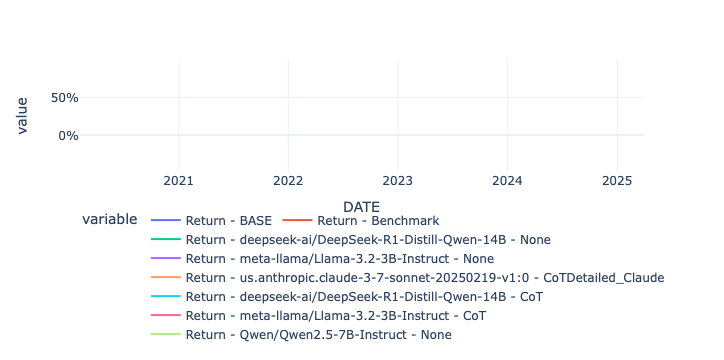

In [19]:
fig = px.line(df_charts)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_layout(legend=dict(
    orientation="h",
    y=-0.3
    ))
fig.show()

### Subplot of all strategies
Create a subplot of all of the strategies to view side by side with the Base Strategy and Benchmark performance. 

In [20]:
df_sub_plots = format_chart_subplots(trade_results, df_baseline)

In [21]:
figs = []
titles = []
for chart_data in df_sub_plots:
    figs.append(px.line(chart_data))
    titles.append(chart_data.columns[-1])

In [23]:
fig2 = make_subplots(rows=len(figs), subplot_titles=titles, row_heights=[150,150,150,150,150,150])

In [24]:
for i, figure in enumerate(figs):
    for trace in range(len(figure["data"])):
        fig2.append_trace(figure["data"][trace], row=i+1, col=1)

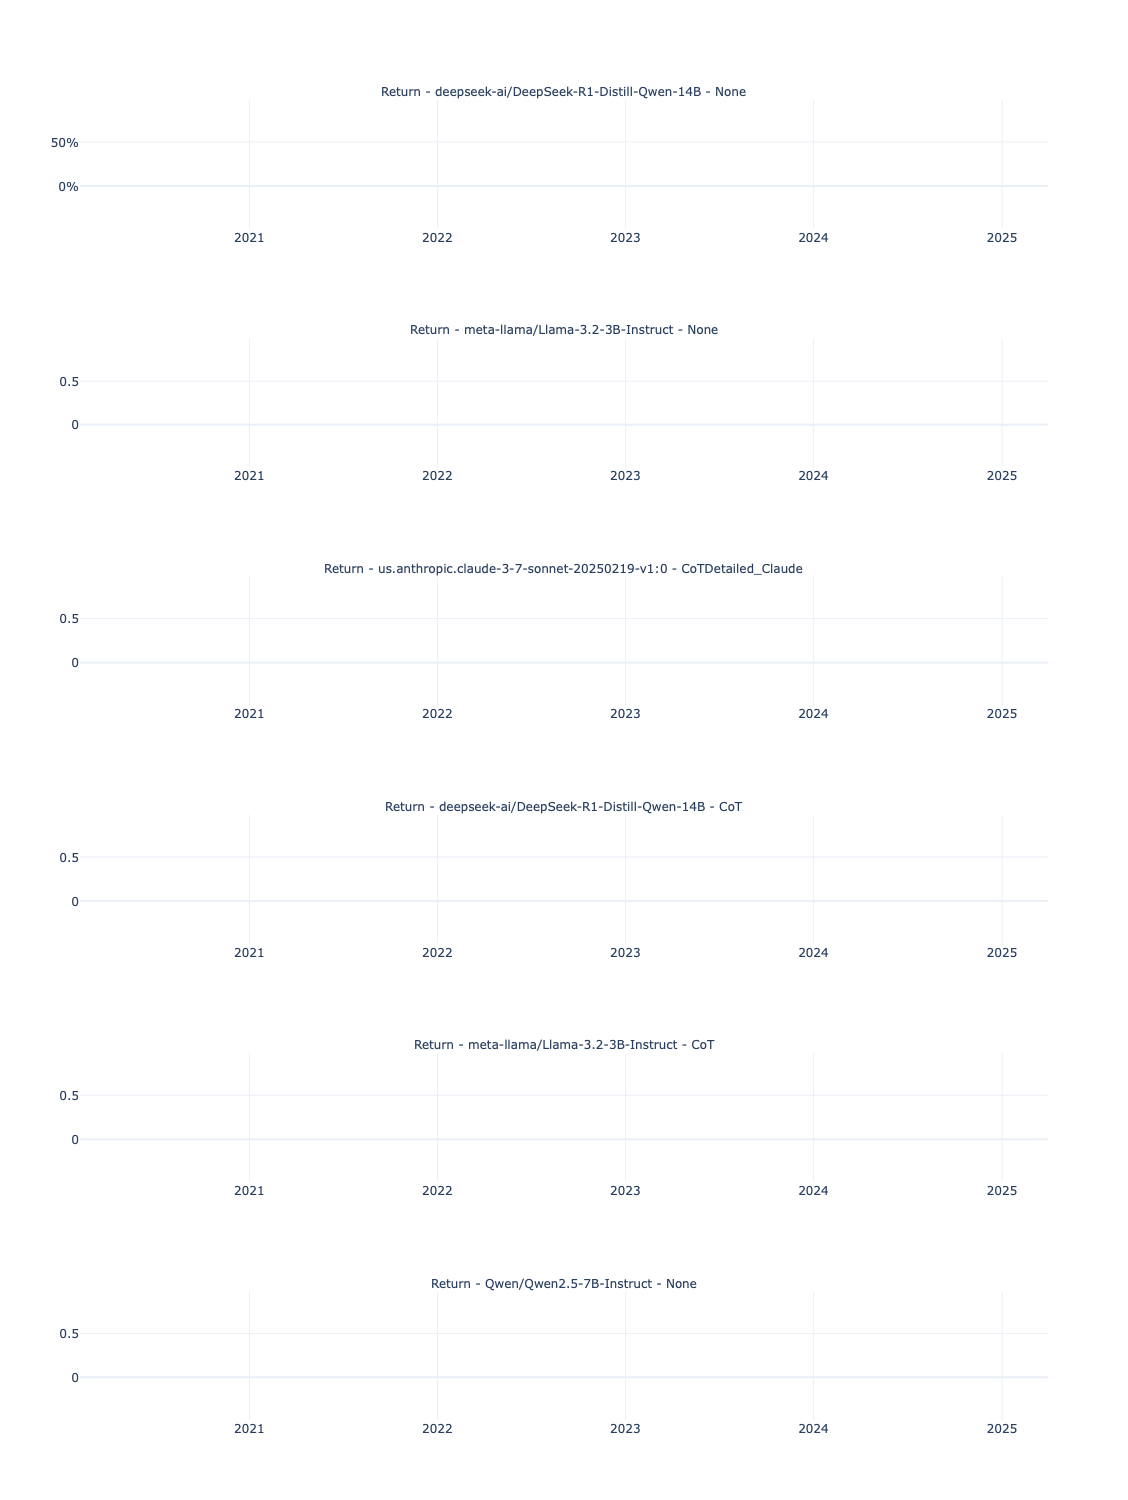

In [28]:
fig2.update_layout(height=1500, showlegend=False, width=700, )
fig2.update_annotations(font_size=12)
fig2.layout.yaxis.tickformat = ',.0%'
fig2.show()

In [89]:
num = 0
trade_analytics[list(results.keys())[num]].plot_analytics()
print(list(results.keys())[num ])

deepseek-ai/DeepSeek-R1-Distill-Qwen-14B - None


## Agentic Strategies

The next step is to look at the performance of our agentic system. We use the same methodology as the performance of the strategies 

In [68]:
with open('Results/Agentic/trades_llama_v4.json', 'rb') as f:
    agentic_trades = json.load(f)

In [69]:
trades = pd.DataFrame(data=agentic_trades).rename(columns={'date':'Date','decision':'Decision', 'confidence':'Confidence', 'security':'Security'})
#trades = trades[trades['Date'] <= '2025-03-31'][['Date', 'Security', 'Decision', 'Confidence']]

In [70]:
agentic_results = backtest.run(trades,'agentic')

100%|██████████| 117/117 [00:38<00:00,  3.00it/s]


In [71]:
df_agent_strategy, df_agent_benchmark = backtest.get_return_data()

In [72]:
# Format the dataframes to create a single dataframe for the chart
df_baseline = df_chart.copy(deep=True)
df1 = df_agent_strategy[['Cum. Return (Gross)']]

In [73]:
df_baseline = df_baseline.merge(df1, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)': f'Return - Agent'})

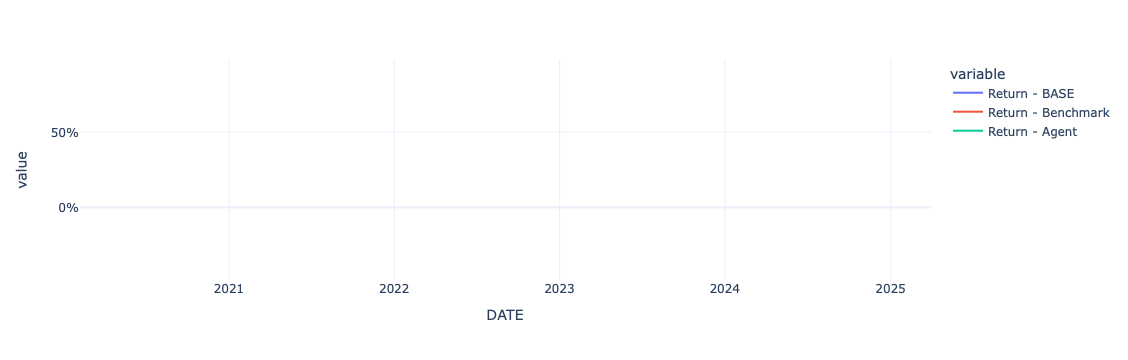

In [74]:
fig = px.line(df_baseline)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

In [75]:
agentic_results.plot_analytics()

In [78]:
def earning_decision(df):
    if df['earning_decision'] == 'increase':
        return 'BUY'
    elif df['earning_decision'] == 'decrease':
        return 'SELL'
    else:
        return 'HOLD'

In [79]:
trades['Earning_Recommendation'] = trades.apply(earning_decision, axis=1)

In [80]:
trades_earning = trades[trades['Date'] <= '2025-03-31'][['Date', 'Security', 'Earning_Recommendation', 'Confidence']]

In [81]:
trades_earning = trades_earning.rename(columns={'Earning_Recommendation':'Decision'})

In [82]:
agentic_results_v2 = backtest.run(trades_earning,'agentic')

100%|██████████| 117/117 [00:42<00:00,  2.76it/s]


In [83]:
df_agent_earning_strategy, df_agent_benchmark = backtest.get_return_data()

In [84]:
df_agent_earning_strategy

Cum. Return (Gross)  Cum. Return (Net)  Cum. T-Cost
DATE                                                           
2020-02-07             0.000000           0.000000         -0.0
2020-02-10             0.000000           0.000000         -0.0
2020-02-11            -0.003806          -0.003806         -0.0
2020-02-12            -0.003794          -0.003794         -0.0
2020-02-13             0.004608           0.004608         -0.0
...                         ...                ...          ...
2025-03-25            -0.067804          -0.067804         -0.0
2025-03-26            -0.063664          -0.063664         -0.0
2025-03-27            -0.064345          -0.064345         -0.0
2025-03-28            -0.063644          -0.063644         -0.0
2025-03-31            -0.058750          -0.058750         -0.0

[1293 rows x 3 columns]

In [85]:
df1 = df_agent_earning_strategy[['Cum. Return (Gross)']]
df_baseline = df_baseline.merge(df1, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)': f'Return - Agent - Earnings'})

In [86]:
fig = px.line(df_baseline)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Single Inference Strategy Analysis

In [17]:
# load the data
with open('Results/results - 2025-03-23 22:51:33.591349.json', 'rb') as file:
    base = json.load(file)

In [18]:
results = base['results']

In [19]:
trades = tg.generate_trade_report(results)
trades_df = pd.DataFrame(data=trades)

In [20]:
trades_df

Date        Security Decision  Confidence
0    2020-02-06   MMM UN Equity     SELL          75
1    2020-02-12  CSCO UW Equity     SELL          75
2    2020-02-12  AMGN UQ Equity     SELL          75
3    2020-02-13   AXP UN Equity      BUY          80
4    2020-02-13  NVDA UQ Equity      BUY          85
..          ...             ...      ...         ...
891  2025-01-31   XOM UN Equity     SELL          75
892  2025-02-04   PFE UN Equity      BUY          70
893  2025-02-04   MRK UN Equity      BUY          75
894  2025-02-04  AMGN UW Equity      BUY          75
895  2025-02-04  AMGN UQ Equity      BUY          75

[896 rows x 4 columns]

In [25]:

def explore_data(df):
    #print("Number Missing: ", df['Decision'].value_counts()['Missing'])
    print("Number of Buy: ", df['Decision'].value_counts()['BUY'])
    print("Number of Sell: ", df['Decision'].value_counts()['SELL'])
    print("Number of Hold: ", df['Decision'].value_counts()['HOLD'])

In [ ]:
trades_df['Decision'].value_counts()['SELL']

In [26]:
explore_data(trades)

Number of Buy:  94
Number of Sell:  532
Number of Hold:  267


In [ ]:
backtest = es.EventBacktest(start=start, 
                            end=end, 
                            universe_name=universe_name, 
                            data_pack_path=datapack_path)
backtest_output = backtest.run(trades_df, 'claude - 0.5')

In [ ]:
df_strategy, df_benchmark = backtest.get_return_data()
trade_results['claude - 0.7']

In [28]:
confident_trades = trades_df[trades_df['Confidence'] >= 80]

array([[<AxesSubplot:title={'center':'Confidence'}>]], dtype=object)

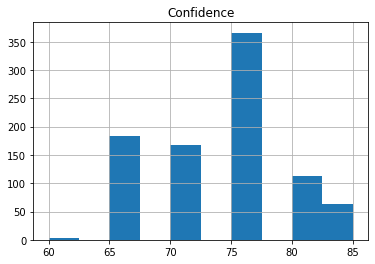

In [29]:
trades_df.hist(column='Confidence')

In [30]:
backtest_output = backtest.run(confident_trades, 'confident')


100%|██████████| 117/117 [00:38<00:00,  3.02it/s]


In [31]:
df_strategy, df_benchmark = backtest.get_return_data()

In [32]:
trade_results['confident'] = df_strategy

In [45]:
results.plot_analytics()